In [1]:
from gurobipy import *

In [53]:
def IPS6(ship_num,stack_num,height,n,size,size_,beta,mean,cov):
  O1=[i+1 for i in range(ship_num)]
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  # 期待値と分散共分散行列の準備
  np.random.seed()
  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  O=O_.tolist()
  # a=[]
  # b={}
  # for i in O:
  #   # print(i)
  #   if not i in a:
  #     a.append(i)
  #     for j in a:
  #       b[tuple(j)]=O.count(j)

  m=Model("IPS6")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(O):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(O)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")

  print("================================================")

# def result(self):
  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
    # for (i) in d:
    #   if d[i].X>EPS:
    #     print("d[%2s]=%3s" %(i,d[i].X))

    # for (s,h,i) in c:
    #   if c[s,h,i].X>EPS:
    #     print("c[%2s,%2s,%2s]=%3s  %4s" %(s,h,i,c[s,h,i].X,O[i]))

    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
    # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    print(result)

    np.random.seed()
    data_2 = np.random.multivariate_normal(mean, cov, size=size_)

    global OR
    OR_=np.argsort(data_2)
    OR_=OR_+np.ones((size_,ship_num)).astype(int)
    OR=OR_.tolist()

    global penalty
    penalty=[]
    for k in OR:
      O=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if O.index(result[i-1][j])>O.index(result[i_-1][j]):
                          print(j+1,height-i+1,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      # print(a)
    penalty=np.sort(penalty)
    penalty=penalty[round(0.75*size_):]
    # penalty=penalty[round(0.8*size):]
    # print(penalty)

def robust(ship_num,stack_num,height,n,Gamma,size,size_,mean,cov):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    O1=[i+1 for i in range(ship_num)]

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")
        # for (s,h,p,t) in x:
        #   if t==len(T):
        #     if x[s,h,p,t].X>EPS:
        #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

        # for (i,q) in beta:
        #     if beta[i,q].X>EPS:
                # print("beta[%2s,%2s]=%3s" %(gamma[i-1],q,beta[i,q].X))

        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal

        np.random.seed()
        data_1 = np.random.multivariate_normal(mean, cov, size=size_)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size_,ship_num)).astype(int)
        OR=O_.tolist()


        global penalty_r
        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                            if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                                a+=1
                                if Gamma ==2:
                                  print(j+1,height-i+1,O)
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
        
        penalty_r=np.sort(penalty_r)
        penalty_r=penalty_r[round(0.75*size_):]
        # print(penalty_r)

        # import matplotlib.pyplot as plt
        # plt.boxplot(penalty_r)

## 分散を変える

#### 分散1

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x4283ad5c
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 133400 rows and 11960 columns
Presolve time: 2.39s
Presolved: 11634 rows, 1137 columns, 93616 nonzeros
Variable types: 1041 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.1160000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 222 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.

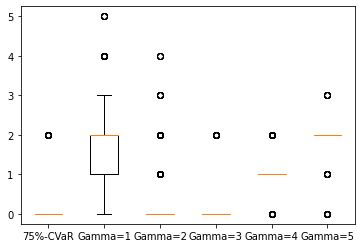

In [9]:
size=1000
size_=10000
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[1 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散2

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0xc8f1be6d
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 121655 rows and 10907 columns
Presolve time: 1.98s
Presolved: 23379 rows, 2190 columns, 188062 nonzeros
Variable types: 2094 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.3040000
Found heuristic solution: objective 4.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 423 iterations, 0.13 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

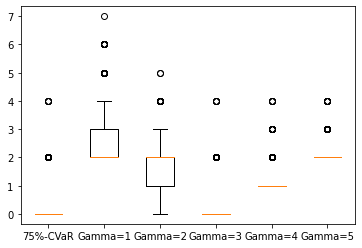

In [10]:
size=1000
size_=10000
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[2 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散3

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0xaa226501
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 114405 rows and 10257 columns
Presolve time: 2.04s
Presolved: 30629 rows, 2840 columns, 246362 nonzeros
Variable types: 2744 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.3800000
Found heuristic solution: objective 4.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 639 iterations, 0.18 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

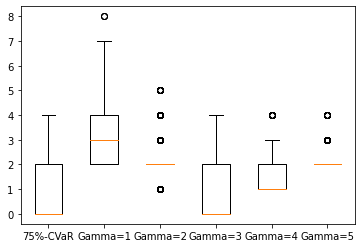

In [12]:
size=1000
size_=10000
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[3 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散4

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x0395b786
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 109185 rows and 9789 columns
Presolve time: 1.92s
Presolved: 35849 rows, 3308 columns, 288338 nonzeros
Variable types: 3212 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.5120000
Found heuristic solution: objective 4.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 502 iterations, 0.16 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

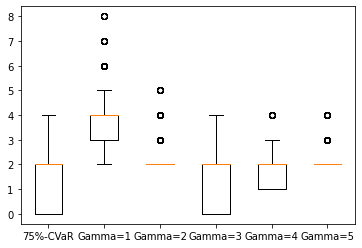

In [13]:
size=1000
size_=10000
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[4 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散5

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x6b4d5e3b
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 103820 rows and 9308 columns
Presolve time: 1.75s
Presolved: 41214 rows, 3789 columns, 331480 nonzeros
Variable types: 3693 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.4920000
Found heuristic solution: objective 4.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 580 iterations, 0.18 seconds (0.24 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

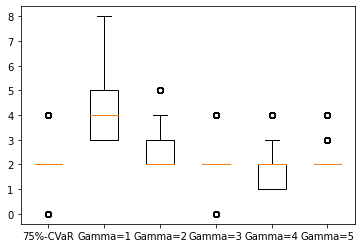

In [14]:
size=1000
size_=10000
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[5 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

## より複雑なモデルに対応

C:\Users\Owner\AppData\Local\Temp\ipykernel_13612\4052243741.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x2689d024
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 110635 rows and 9919 columns
Presolve time: 1.79s
Presolved: 34399 rows, 3178 columns, 276678 nonzeros
Variable types: 3082 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.1720000
Found heuristic solution: objective 4.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 753 iterations, 0.16 seconds (0.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

C:\Users\Owner\AppData\Local\Temp\ipykernel_13612\4052243741.py:106: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size_)


[2, 3, 5, 4, 1, 6]
3 3 [2, 3, 5, 4, 1, 6]
1 3 [2, 4, 1, 5, 3, 6]
1 3 [2, 5, 4, 3, 6, 1]
3 3 [2, 5, 4, 3, 6, 1]
4 4 [3, 1, 5, 6, 4, 2]
4 3 [3, 1, 5, 6, 4, 2]
1 3 [5, 2, 6, 4, 1, 3]
3 3 [5, 2, 6, 4, 1, 3]
1 3 [2, 3, 4, 1, 6, 5]
3 3 [2, 3, 5, 1, 6, 4]
1 3 [4, 3, 1, 2, 5, 6]
3 3 [2, 5, 1, 3, 4, 6]
3 3 [2, 3, 6, 5, 1, 4]
3 3 [5, 1, 4, 2, 3, 6]
4 4 [1, 3, 4, 5, 6, 2]
4 3 [1, 3, 4, 5, 6, 2]
4 4 [1, 6, 3, 2, 4, 5]
4 3 [1, 6, 3, 2, 4, 5]
3 3 [2, 5, 1, 4, 3, 6]
4 4 [1, 3, 4, 6, 2, 5]
4 3 [1, 3, 4, 6, 2, 5]
3 3 [5, 1, 3, 6, 2, 4]
4 4 [5, 1, 3, 6, 2, 4]
4 3 [5, 1, 3, 6, 2, 4]
1 3 [4, 1, 3, 2, 6, 5]
4 4 [1, 6, 3, 2, 5, 4]
4 3 [1, 6, 3, 2, 5, 4]
3 3 [3, 2, 5, 1, 6, 4]
3 3 [5, 1, 6, 3, 2, 4]
4 4 [5, 1, 6, 3, 2, 4]
4 3 [5, 1, 6, 3, 2, 4]
3 3 [3, 5, 1, 2, 4, 6]
1 3 [2, 3, 5, 4, 6, 1]
3 3 [2, 3, 5, 4, 6, 1]
3 3 [5, 1, 6, 4, 2, 3]
4 4 [5, 1, 6, 4, 2, 3]
4 3 [5, 1, 6, 4, 2, 3]
4 4 [1, 5, 3, 6, 4, 2]
4 3 [1, 5, 3, 6, 4, 2]
1 3 [3, 5, 4, 2, 1, 6]
3 3 [3, 5, 4, 2, 1, 6]
4 4 [1, 3, 6, 2, 5, 4]
4 3 [1, 3, 6, 2

C:\Users\Owner\AppData\Local\Temp\ipykernel_13612\4052243741.py:234: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size_)


[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

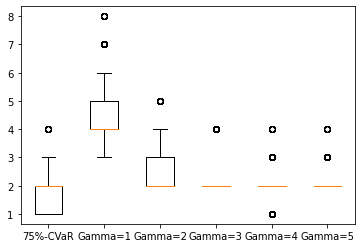

In [19]:
size=1000
size_=10000
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[3,2,1,1,3,3]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

cov[0][4]=-6
cov[4][0]=cov[0][4]
cov[1][4]=6
cov[4][1]=cov[1][4]
cov[1][5]=6
cov[5][1]=cov[1][5]

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

## コンテナの数を変更

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x22a42790
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 133036 rows and 11908 columns
Presolve time: 2.70s
Presolved: 11998 rows, 1189 columns, 97416 nonzeros
Variable types: 1093 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.0200000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.200000e-02, 394 iterations, 0.07 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.

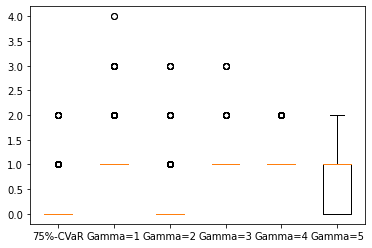

In [54]:
size=1000
size_=10000
inst=[4,4,[2,2,1,1,3,3]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[1,1,1,1,1,1]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0
# cov[1][4]=-0.8
# cov[4][1]=cov[1][4]
# cov[0][3]=-0.8
# cov[3][0]=cov[0][3]
# cov[1][5]=6
# cov[5][1]=cov[1][5]

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x1daffb25
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 133556 rows and 11960 columns
Presolve time: 2.19s
Presolved: 11478 rows, 1137 columns, 92992 nonzeros
Variable types: 1041 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.0320000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.000000e-02, 278 iterations, 0.05 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.

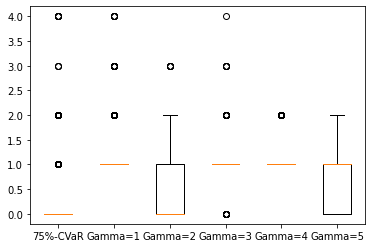

In [52]:
size=1000
size_=10000
inst=[4,4,[2,2,1,1,3,3]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[1,1,1,1,1,1]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0
# cov[1][4]=-0.8
# cov[4][1]=cov[1][4]
cov[0][3]=-0.8
cov[3][0]=cov[0][3]
# cov[1][5]=6
# cov[5][1]=cov[1][5]

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

## 5×4

#### 分散1

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-03
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0x24ed910b
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 183883 rows and 12208 columns
Presolve time: 4.06s
Presolved: 57160 rows, 3953 columns, 573389 nonzeros
Variable types: 3793 continuous, 160 integer (160 binary)
Found heuristic solution: objective 7.5160000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 766 iterations, 0.36 seconds (0.40 work units)
Total elapsed time = 5.11s

    Nodes    |    Current Node    |     Object

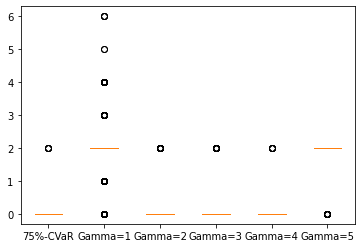

In [3]:
size=1000
size_=10000
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[1 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散2

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0xb31e2bbc
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 132309 rows and 8784 columns (presolve time = 5s) ...
Presolve removed 132309 rows and 8784 columns
Presolve time: 5.05s
Presolved: 108734 rows, 7377 columns, 1090627 nonzeros
Variable types: 7217 continuous, 160 integer (160 binary)
Found heuristic solution: objective 7.6680000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          6s
    1257   -0.0000000e+00   0.000000e+00   0.000000e+00      6s
    1257   -0.0000000e+00   0.000000e

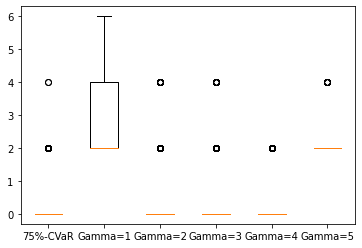

In [4]:
size=1000
size_=10000
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[2 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散3

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0x0c7fe16f
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 91339 rows and 6064 columns (presolve time = 5s) ...
Presolve removed 91339 rows and 6064 columns
Presolve time: 5.88s
Presolved: 149704 rows, 10097 columns, 1501517 nonzeros
Variable types: 9937 continuous, 160 integer (160 binary)
Found heuristic solution: objective 8.0960000

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.600000e+01      8s
     664   

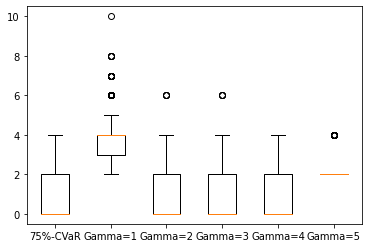

In [5]:
size=1000
size_=10000
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[3 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散4

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0x04015cf5
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 68926 rows and 4576 columns (presolve time = 5s) ...
Presolve removed 68926 rows and 4576 columns
Presolve time: 5.72s
Presolved: 172117 rows, 11585 columns, 1726298 nonzeros
Variable types: 11425 continuous, 160 integer (160 binary)
Found heuristic solution: objective 8.0560000

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.600000e+01      7s
     761  

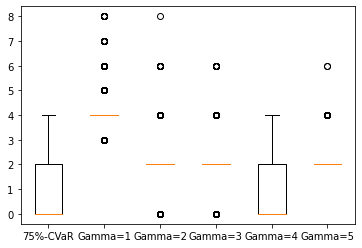

In [6]:
size=1000
size_=10000
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
covl=[4 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

## 平均ベクトルの変更

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0xc74d25c9
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 126043 rows and 8368 columns
Presolve time: 4.27s
Presolved: 115000 rows, 7793 columns, 1153469 nonzeros
Variable types: 7633 continuous, 160 integer (160 binary)
Found heuristic solution: objective 7.6160000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          5s
    1919   -0.0000000e+00   0.000000e+00   0.000000e+00      5s
    1919   -0.0000000e+00   0.000000e+00   0.000000e+00      5s
    1919    0.0000000e+00   0.000000e+00   0

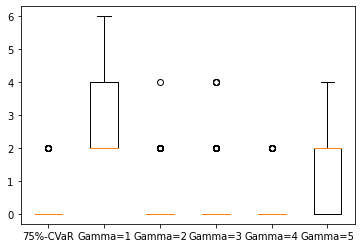

In [5]:
size=1000
size_=2000
loc=2
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.array([1,1.5,2.8,4,5,7,7.5,8])
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散3

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0xfbe361a9
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 96400 rows and 6400 columns (presolve time = 5s) ...
Presolve removed 96400 rows and 6400 columns
Presolve time: 5.46s
Presolved: 144643 rows, 9761 columns, 1450760 nonzeros
Variable types: 9601 continuous, 160 integer (160 binary)
Found heuristic solution: objective 7.8000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          7s
    1811   -0.0000000e+00   0.000000e+00   0.000000e+00      7s
    1811   -0.0000000e+00   0.000000e+0

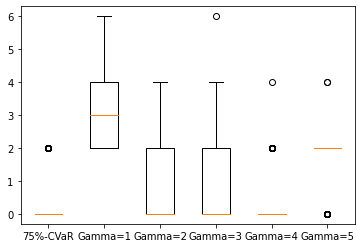

In [6]:
size=1000
size_=2000
loc=3
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.array([1,1.5,2.8,4,5,7,7.5,8])
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散4

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0x37f9ea81
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 74469 rows and 4944 columns (presolve time = 5s) ...
Presolve removed 74469 rows and 4944 columns
Presolve time: 5.18s
Presolved: 166574 rows, 11217 columns, 1670707 nonzeros
Variable types: 11057 continuous, 160 integer (160 binary)
Found heuristic solution: objective 8.0000000

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.600000e+01      7s
     729  

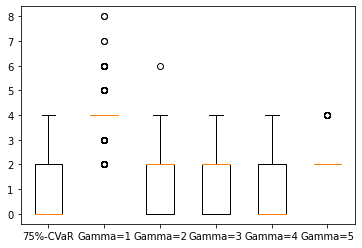

In [7]:
size=1000
size_=2000
loc=4
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.array([1,1.5,2.8,4,5,7,7.5,8])
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散5

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 241043 rows, 16161 columns and 2417560 nonzeros
Model fingerprint: 0xa3ffa964
Variable types: 16001 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 52779 rows and 3504 columns (presolve time = 5s) ...
Presolve removed 52779 rows and 3504 columns
Presolve time: 5.20s
Presolved: 188264 rows, 12657 columns, 1888237 nonzeros
Variable types: 12497 continuous, 160 integer (160 binary)
Found heuristic solution: objective 8.1600000

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.600000e+01      7s
     815  

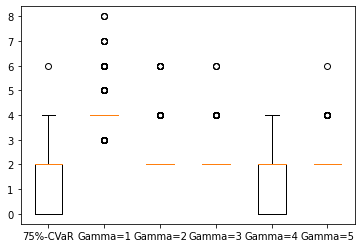

In [9]:
size=1000
size_=2000
loc=5
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.array([1,1.5,2.8,4,5,5.1,7.5,8])
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()